In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN

savepath = "results/P1Q2/"

In [10]:
C   = 1.0      
gL  = 0.1      
EL  = -65.0    
VR  = -65.0    
VT  = -50.0    
ES  =   0.0 

gS_vals = np.linspace(0.0, 1.0, 400)

In [11]:
def eff_params(gS):
    """
    """
    gtot = gL + gS
    Vinf = (gL*EL + gS*ES) / gtot
    tau  = C / gtot  
    return tau, Vinf

def firing_rate_from_gS(gS):
    """
    """
    tau, Vinf = eff_params(gS)
    if Vinf <= VT:
        return 0.0
    num = Vinf - VR
    den = Vinf - VT
    if num <= 0 or den <= 0 or num <= den:
        return 0.0
    T = tau * np.log(num / den)  
    return 1.0 / T   

def rheobase_gS():
    """
    """
    if ES <= VT:
        return np.inf
    return gL * (VT - EL) / (ES - VT)

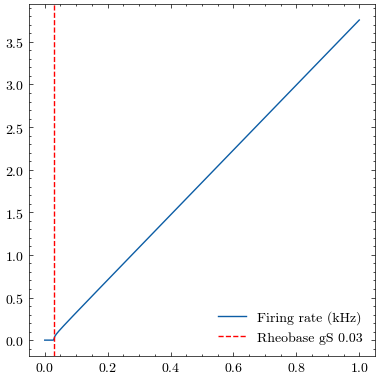

In [12]:
rate_kHz = np.array([firing_rate_from_gS(g) for g in gS_vals])       
rate_Hz  = 1000.0 * rate_kHz                                        
gS_rh = rheobase_gS()

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(gS_vals, rate_kHz, label='Firing rate (kHz)')
ax.axvline(gS_rh, color='red', linestyle='--', label=f'Rheobase gS {gS_rh:.2f}')
ax.legend()
fig.tight_layout()
fig.savefig(savepath + "firing_rate_vs_gS.png", dpi=300)

In [13]:
def simulate_trace(gS=0.3, T_sim=300.0, dt=0.01, t_ref=0.0):
    """
    """
    n = int(T_sim/dt)
    V = np.empty(n); t = np.arange(n)*dt
    v = VR
    ref_counter = 0.0
    spikes = []
    for i in range(n):
        if ref_counter > 0:
            v = VR
            ref_counter -= dt
        else:
            dV = ( -gL*(v-EL) - gS*(v-ES) ) / C
            v += dt*dV
            if v >= VT:
                spikes.append(t[i])
                v = VR
                ref_counter = t_ref
        V[i] = v
    return t, V, np.array(spikes)

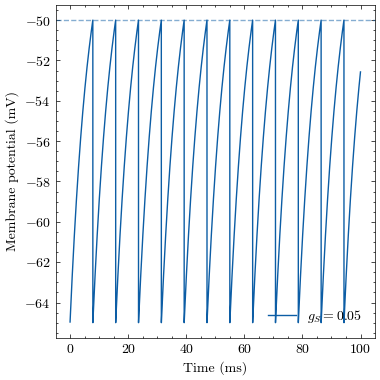

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
gS_examples = [0.05]  
for gS in gS_examples:
    t, V, spk = simulate_trace(gS=gS, T_sim=100.0, dt=0.01)
    ax.plot(t, V, label=fr"$g_S={gS}$")
ax.axhline(VT, ls='--', alpha=0.5, lw=1)
ax.legend()
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Membrane potential (mV)")
fig.tight_layout()
fig.savefig(savepath + "example_trace.png", dpi=300)

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_93078/133757528.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set2', 4)


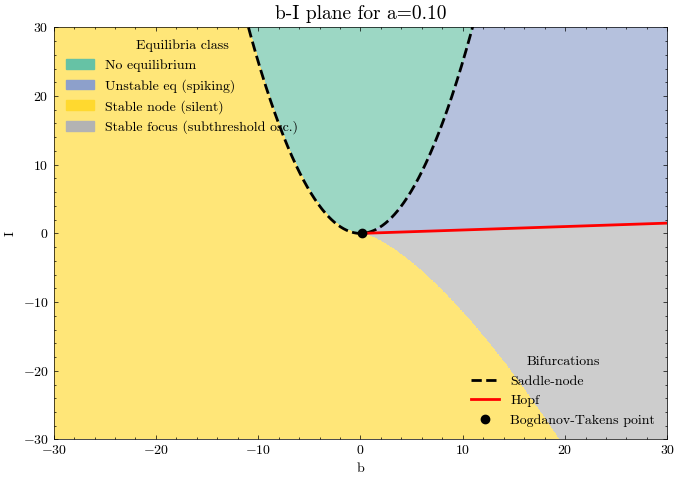

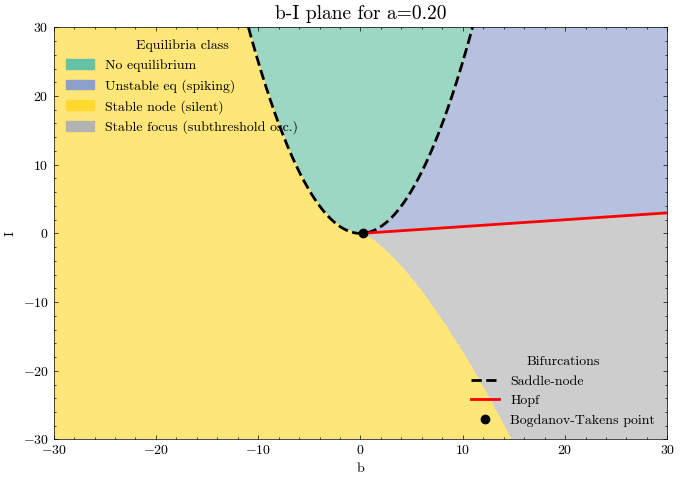

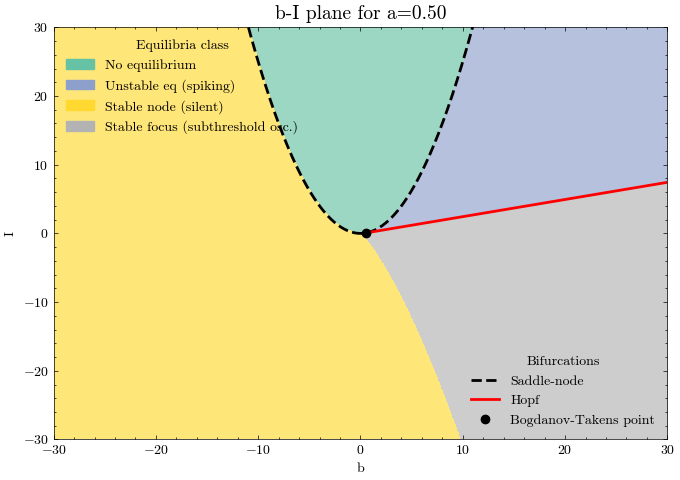

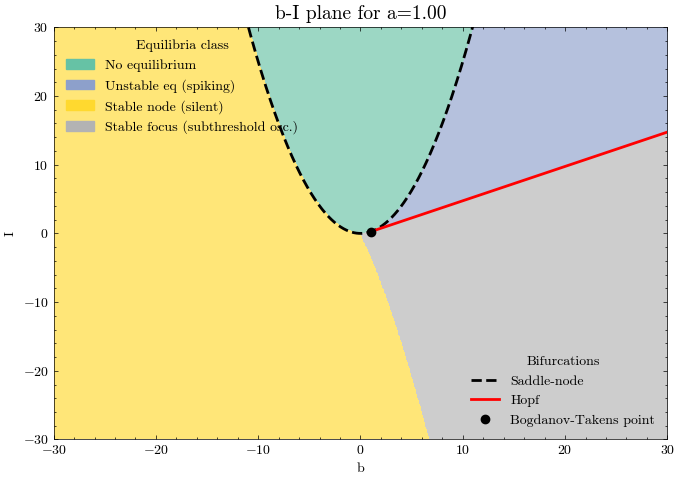

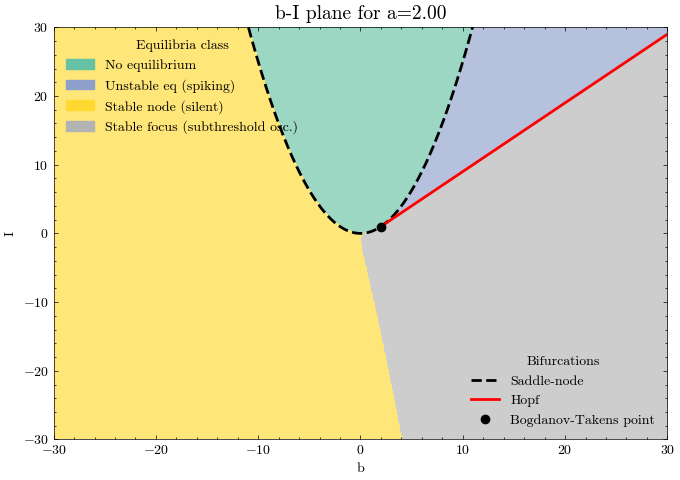

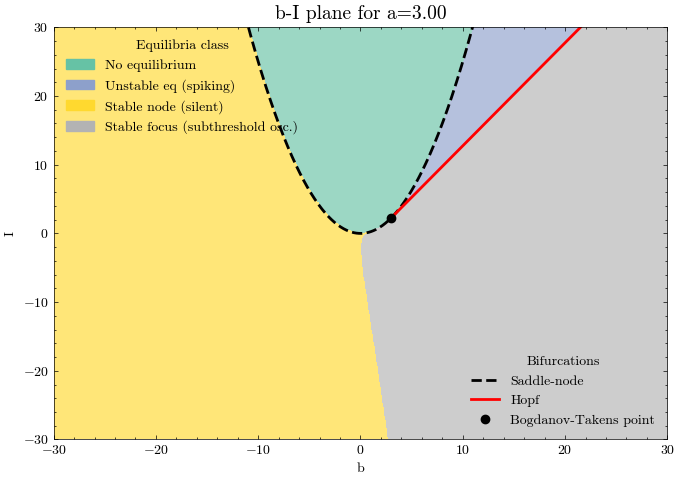

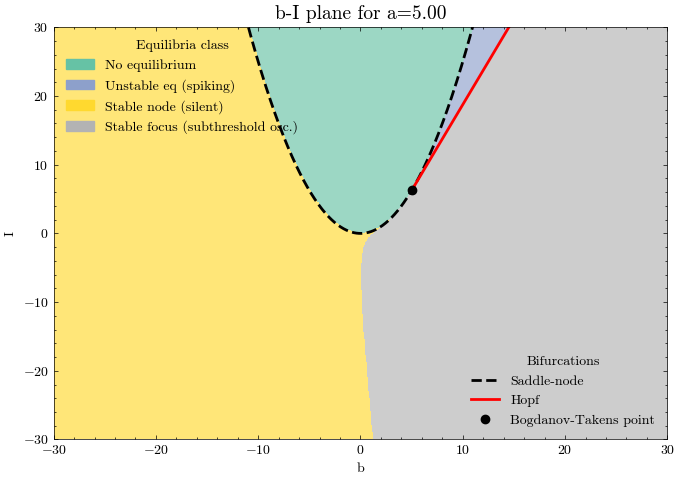

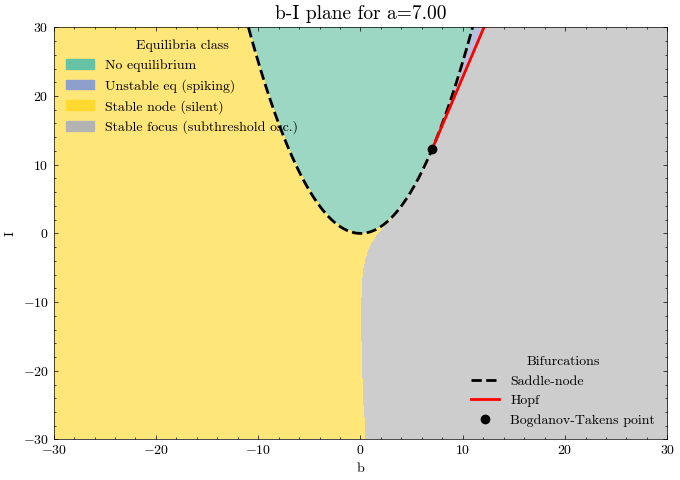

In [15]:
a_lst = [0.1,0.2,0.5,1.0,2.0,3.0,5.0,7.0]

for a in a_lst:
    b_min, b_max = -30.0, 30.0
    I_min, I_max = -30.0, 30.0
    gridnum = 1000
    b = np.linspace(b_min, b_max, gridnum)
    I = np.linspace(I_min, I_max, gridnum)
    Bgrid, Igrid = np.meshgrid(b, I, indexing='xy')

    det_equ = Bgrid**2 - 4*Igrid
    has_eq = det_equ >= 0

    Vminus = np.full_like(Bgrid, np.nan)
    Vminus[has_eq] = 0.5*(Bgrid[has_eq] - np.sqrt(det_equ[has_eq]))

    Tr  = 2*Vminus - a
    Det = a*(Bgrid - 2*Vminus)

    # 0: tonic spiking, 1: unstable (Hopf side), 2: stable node, 3: stable focus
    cls = np.zeros_like(Bgrid)

    # no equilibria
    cls[~has_eq] = 0

    # where two equilibria exist:
    mask = has_eq.copy()

    stable = mask & (Tr < 0)

    disc = Tr**2 - 4*Det
    stable_focus = stable & (disc < 0) & (Tr < 0)
    stable_node  = stable & (disc >= 0) & (Tr < 0)

    cls[stable_focus] = 3
    cls[stable_node]  = 2

    unstable = mask & (Tr >= 0)
    cls[unstable] = 1

    cmap = plt.cm.get_cmap('Set2', 4) 

    plt.figure(figsize=(7,5))
    ax = plt.gca()

    I_for_b = np.linspace(I_min, I_max, gridnum)
    b_hopf = a/2 + (2/a)*I_for_b
    # valid = b_hopf >= a
    valid = (b_hopf >= a) & (I_for_b < 0.25*b_hopf**2)

    line_sn,   = ax.plot(b, 0.25*b**2, 'k--', lw=2, label='Saddle-node')
    line_hopf, = ax.plot(b_hopf[valid], I_for_b[valid], 'r-', lw=2, label='Hopf')
    saddle_node, = ax.plot(a, a**2/4, 'ko', label='Bogdanov-Takens point')

    plt.imshow(cls, origin='lower', extent=[b_min,b_max,I_min,I_max], aspect='auto',
            cmap=cmap, alpha=0.65, interpolation='nearest')

    labels = ['No equilibrium', 'Unstable eq (spiking)',
            'Stable node (silent)', 'Stable focus (subthreshold osc.)']
    patches = [mpatches.Patch(color=cmap(i/3.), label=lab) for i, lab in enumerate(labels)]
    leg_regions = ax.legend(handles=patches, loc='upper left', framealpha=1.0, title='Equilibria class')
    ax.add_artist(leg_regions)

    ax.legend(handles=[line_sn, line_hopf, saddle_node], 
              loc='lower right', framealpha=1.0, title='Bifurcations')

    ax.set_xlabel('b')
    ax.set_ylabel('I')
    ax.set_xlim(b_min, b_max)
    ax.set_ylim(I_min, I_max)
    ax.set_title(f"b-I plane for a={a:.2f}", fontsize=14)
    plt.tight_layout()
    plt.savefig(savepath + f"b_I_plane_a={a}.png", dpi=1000)